## Predicting surface location using fluorescent beads

Fluorescent beads on a clean coverslip were imaged with confocal laser scanning microscope. Their 3D position have been determined using 3D Gaussian fit. Given their radius, this is enough information to uncover coverslip surface position beneath them. However, bead radius has a wide variation. In this file, we learn how to correct for bead size using various parameters that 3D Gaussian fit spits out and an independent measurment of actual coverslip surface position.

### Prepare data

In [ ]:
# Use seaborn for pairplot
!pip install -q seaborn
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
!git clone https://github.com/masterika/Fluorescence_BSVC.git
import os

#### Download and save data

In [ ]:
# Root directory of the project
ROOT_DIR = os.getcwd()
os.chdir('Fluorescence_BSVC/Datasets')
!unzip coverslip.zip # Results in creating a folder named "bacteria"
bacteria_dataset_path = os.path.join(os.getcwd(), "bacteria")
training_set = pd.read_csv("training.csv")
test_set = pd.read_csv("test.csv")
os.chdir(ROOT_DIR) # go back to root directory

#### Inspect data

In [3]:
training_set.head()

,x,y,dif,z,stdz,stdx,stdy,prop,const,volume,area
0,20.198359,50.389431,0.677966,0.685373,0.569313,0.457312,0.431743,2601.7610,39.635498,8.118041,24.657656
1,19.482264,67.071709,1.093737,1.096864,0.695466,0.613830,0.511789,1859.3854,23.604305,9.049114,28.460499
2,36.249592,204.491290,1.257438,1.178581,0.737368,0.594888,0.539130,2470.9041,22.829016,9.746985,30.854498
3,21.926428,191.900390,0.679600,0.621944,0.616009,0.481582,0.408143,1606.1686,27.165493,7.576985,23.194826
4,38.257160,40.871384,0.514747,0.524693,0.495856,0.390335,0.325898,1678.2833,32.375759,6.274305,18.973665


Column contents are as follows:
- x, y, and z: three dimensional position of fluorescent bead's center, 3D Gaussian fit result
- stdx, stdy and stdz: gaussian spread (standard deviation) of fluorescent bead intensity in x, y and z directions respectively, fit result
- prop: one of the fit coefficients, overal intensity indicator
- const: Offset, fit coefficient
- volume: number of voxels comprising bead
- area: number of pixels surrounding the bead
- dif: the label. Relative z position of bead's center to coverslip surface obtained by substracting coverslip position in bead's vicinity from bead's z position. This uses an independent measurement of coverslip surface position

With 3D Gaussian fit: $$ const+prop\times e^\frac{(x-x_{av})^2}{2stdx^2}e^\frac{(y-y_{av})^2}{2stdy^2}e^\frac{(z-z_{av})^2}{2stdz^2}$$

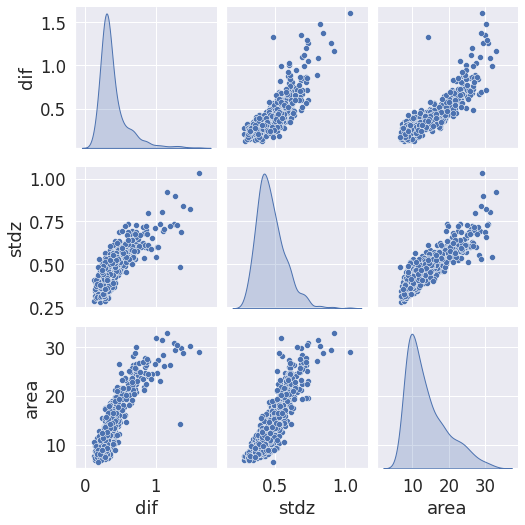

In [4]:
sns.set(font_scale=1.5) 
sns.pairplot(training_set[["dif","stdz","area"]], diag_kind="kde")

#### Separate labels from data

In [5]:
LABEL = "dif"	
training_labels = training_set.pop(LABEL)
test_labels = test_set.pop(LABEL)

#### Normalize data

In [6]:
training_set_n=(training_set-training_set.mean())/training_set.std()
test_set_n=(test_set-training_set.mean())/training_set.std()
# labels are already pretty close to 0-1 range, so we don't normilize them.

### Model

In [7]:
FEATURES = ["stdz","stdx","volume","prop","stdy","area","const"] # set of meaniningful features for dif prediction. stdz feature does most of the job, but rest help.

#### Based on pair-plots above, dif seems to be approximately linear in features. Therefore, first let's see how the most intuitive, linear model will do 

In [8]:
def build_linear_model():
  model = keras.Sequential([        
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

### Training with linear model

In [9]:
model = build_linear_model() 
EPOCHS = 2000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # stop training whenever validation set stops showing improvement
early_history = model.fit(training_set_n[FEATURES], training_labels, 
                    epochs=EPOCHS, validation_split = 0.3, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.3348,  mse:1.3348,  val_loss:1.2712,  val_mse:1.2712,  
....................................................................................................
Epoch: 100, loss:0.0289,  mse:0.0289,  val_loss:0.0322,  val_mse:0.0322,  
....................................................................................................
Epoch: 200, loss:0.0095,  mse:0.0095,  val_loss:0.0096,  val_mse:0.0096,  
............................................

#### Determining error

Text(0, 0.5, 'MSE [μm]')

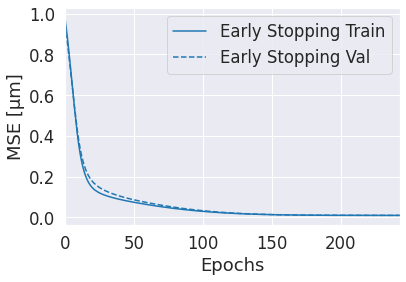

In [10]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': early_history}, metric = "mse")
plt.ylabel('MSE [\u03BCm]')

#### Prediction

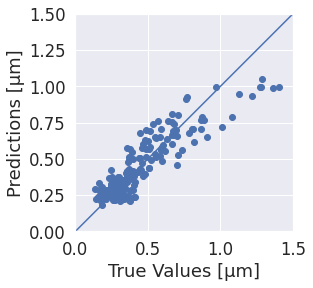

In [11]:
test_predictions = model.predict(test_set_n[FEATURES]).flatten() # using test set to make predictions
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [\u03BCm]')
plt.ylabel('Predictions [\u03BCm]')
lims = [0, 1.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

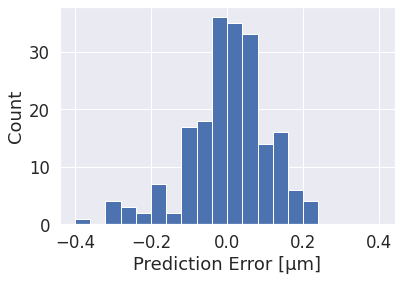

In [12]:
error =[a_i - b_i for a_i, b_i in zip(test_predictions, test_labels)]
plt.hist(error, bins = 20, range = [-0.4,0.4])
plt.xlabel("Prediction Error [\u03BCm]")
_ = plt.ylabel("Count")

##### Eliminating obvious outliers in test set if any

In [13]:
# Simple anomaly detection function
# Takes a list of numbers and a threshold value. Removes any number that is a threshold times standard deviation away from the mean from the list
thresh = 3 # should be adjusted for different test data size
def delouts(mylist,thresh):
  num = 1
  while (num !=0 ):
    num = 0;
    std = np.std(mylist)
    mean = np.mean(mylist)
    for val in mylist:
      if (np.abs(mean-val)>thresh*std):
        mylist.remove(val)
        num = 1;

In [14]:
print("Error before removing outliers (linear model): "+str(round(np.std(error),3))+" [\u03BCm]")
delouts(error,thresh)
print("Error after removing outliers (if any): "+str(round(np.std(error),3))+" [\u03BCm]")
print("Error before correcting for size: "+str(round(np.std(test_labels),3))+" [\u03BCm]")

Error before removing outliers (linear model): 0.136 [μm]
Error after removing outliers (if any): 0.103 [μm]
Error before correcting for size: 0.322 [μm]


### Summary

We have improved the precision of detecting surface using fluorescent beads by capturing the variation of in bead size. Both, linear model and neural network improve the precision by factor three, neural networks performing slightly better. As the relationship looks linear for the big range of the parameter values, it is possible that neural networks will only show significant improvement if the data size is really big.